In [1]:
import os
import matplotlib.pyplot as plt
os.chdir("..")
from model import run_experiments

df = run_experiments(["Base"])


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 365, 64, 2, 27)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (365, 64, 2, 27)
Execution Method: local_simulations
Execution Mode: parallelized
Total execution time: 44.39s


## Extra KPIs

In [2]:
df['n_servicers'] = df['Servicers'].apply(len)
df['n_applications'] = df['Applications'].apply(len)
df['n_gateways'] = df['Gateways'].apply(len)
df['n_services'] = df['Services'].apply(len)

df['n_understaked_servicers'] = df['understaked_servicers'].apply(len)
df['n_understaked_gateways'] = df['understaked_gateways'].apply(len)
df['n_understaked_applications'] = df['understaked_applications'].apply(len)


## Basic Line Graphs

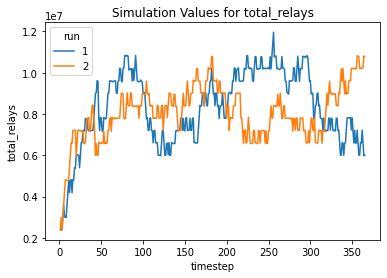

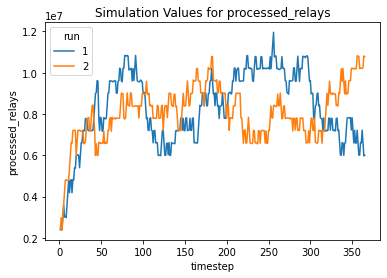

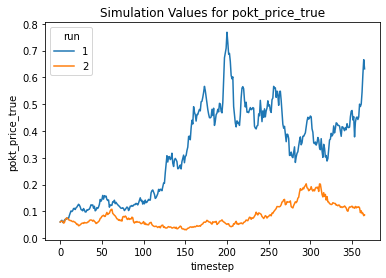

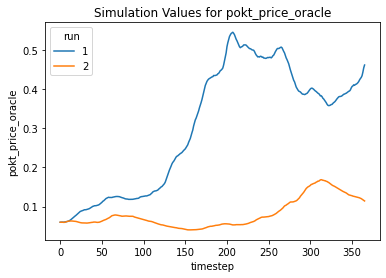

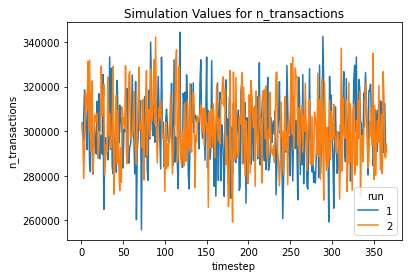

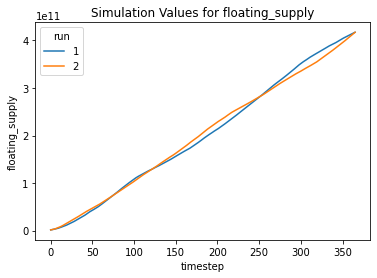

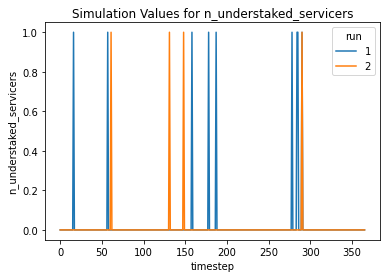

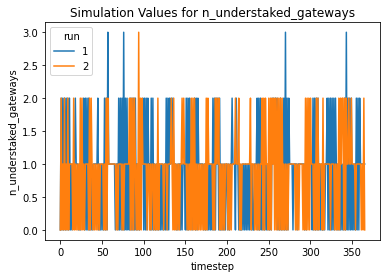

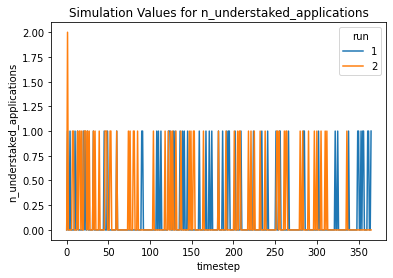

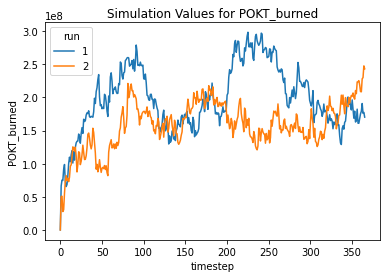

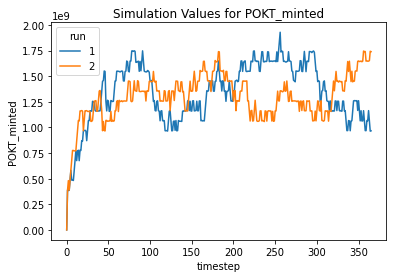

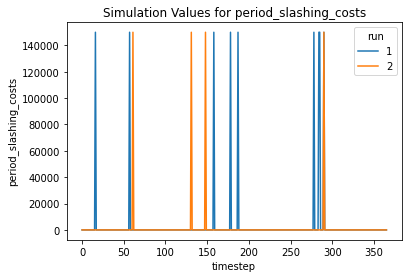

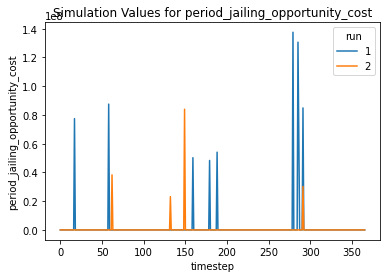

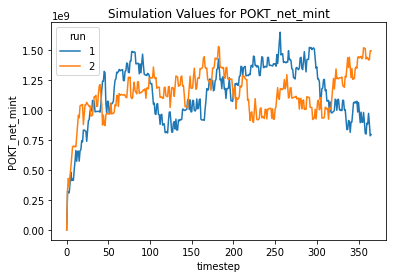

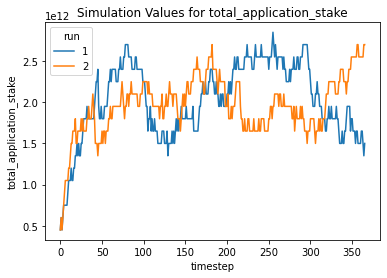

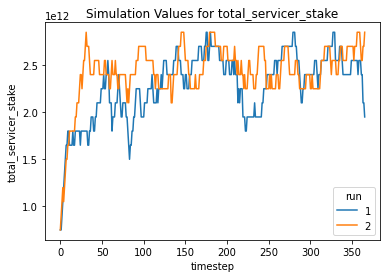

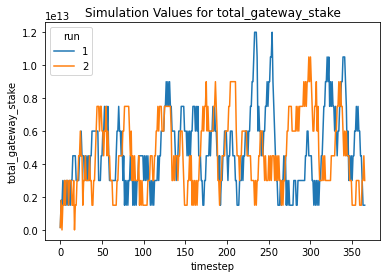

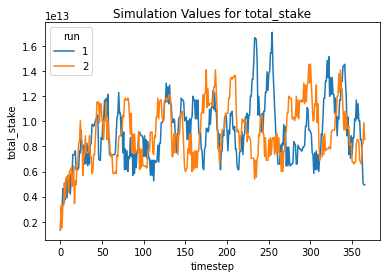

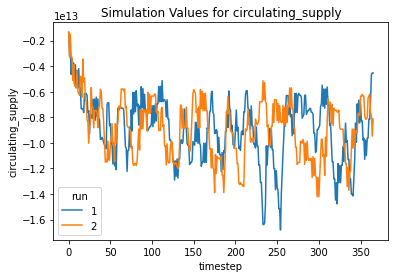

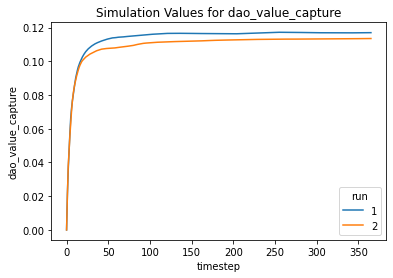

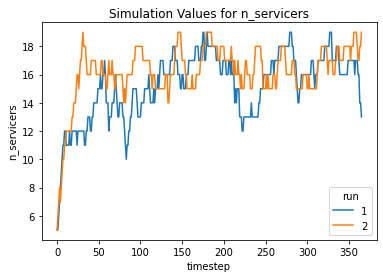

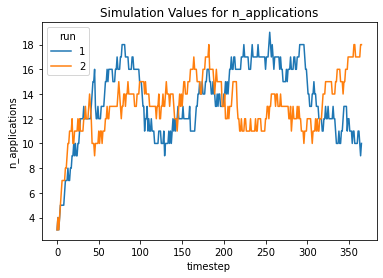

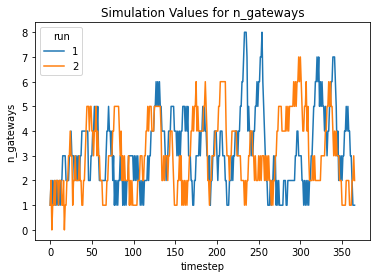

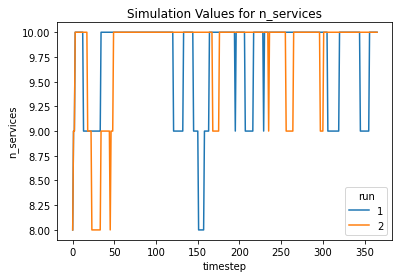

In [3]:
for col in ['total_relays', 'processed_relays', 'pokt_price_true', 'pokt_price_oracle',
           'n_transactions', 'floating_supply', 'n_understaked_servicers', 'n_understaked_gateways',
            'n_understaked_applications', 'POKT_burned', 'POKT_minted','period_slashing_costs',
            'period_jailing_opportunity_cost','POKT_net_mint', 'total_application_stake',
            'total_servicer_stake', 'total_gateway_stake', 'total_stake', 'circulating_supply',
            'dao_value_capture', 'n_servicers', 'n_applications', 'n_gateways',
           'n_services']:
    # Grab the pivot table
    table = df.pivot("timestep", "run", col)
    
    # Plot
    table.plot(kind = 'line')
    plt.xlabel("timestep")
    plt.ylabel(col)
    plt.title("Simulation Values for {}".format(col))
    
    plt.show()